<a href="https://colab.research.google.com/github/Morax19/ML_UCV/blob/main/Tarea2/Tarea2_ML_DanielHernandez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



TAREA 2: APRENDIZAJE SUPERVISADO<br>
Aprendizaje Automático, Escuela de Computación, Facultad de Ciencias - UCV
<br>
<br>
#Parte 1: Reconocimiento de Dígitos
<br>
<br>
Autor: Daniel Hernández<br>
Fecha: 14 de Febrero 2025



## Introducción

---

La función principal de este notebook es utilizar 3 modelos de Aprendizaje Automático con el objetivo de reconocer de dígitos manuscritos, cada modelo tendrá su sección con cada paso realizado, por último se compararán sus rendimientos.

En esta sección se muestran los pasos iniciales tales como la importación de librerías, descarga y pre-procesamiento de datos.


### Configuración del entorno

Lo primero que se define es el valor de la semilla a utilizar a lo largo del notebook, con la finalidad de poder reproducir los resultados.

In [1]:
#El valor de la semilla viene definido previamente
SEED = 27795163

Se importan las librerias necesarias:

In [2]:
import numpy as np
import joblib as jb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

### Pre-procesamiento


El conjunto de datos con el que vamos a trabajar a lo largo de este notebook es [MNIST](https://docs.ultralytics.com/es/datasets/classify/mnist/). Las siglas de este conjunto de datos corresponden a "Modified National Institute of Standards and Technology" la cual es una base de datos que contiene 70 mil imágenes de dígitos desde el 0 hasta el 9, escritos a mano y debidamente identificados.

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Los datos se separan de la siguiente forma:


*   X: Contiene los valores de los píxeles correspondientes a las imágenes
*   y: Contiene las etiquetas asociadas cada una de ellas.



In [4]:
#Valores de los pixeles en un arreglo NumPy
X = np.concatenate((X_train, X_test), axis = 0)

#Etiquetas que identifican los objetivos de las imágenes
y = np.concatenate((y_train, y_test), axis = 0)

Es necesario separar los datos en grupos de entrenamiento y prueba, el conjunto de datos originalmente usa una división de 90% entrenamiento y 10% prueba. En nuestro caso se hará uso de un 70% entrenamiento y un 30% prueba.

Adicional a esto, es necesario vectorizar los valores en X, es decir, aplanar las imágenes originales en un vector de 784 elementos y normalizar sus valores para poder trabajar con los mismos.

In [5]:
#Se separan los datos de entrenamiento y prueba (70 entrenamiento - 30 prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Se vectorizan las imágenes almacenadas en X
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

#Se normalizan los valores X
X_train = X_train / 255.0
X_test = X_test / 255.0

#Finalmente, podemos tener una vista previa de los datos con los que vamos a trabajar
print(f"Cantidad de imágenes para entrenamiento: {X_train.shape[0]}")
print(f"Cantidad de imágenes de prueba: {X_test.shape[0]}")

Cantidad de imágenes para entrenamiento: 49000
Cantidad de imágenes de prueba: 21000


##   1. Regresión Logística

Nuestro objetivo principal es, dada una imagen, determinar a que dígito entre el 0 y el 9 corresponde la misma. Es por esto que nos encontramos ante un problema de clasificación que buscaremos resolver haciendo uso del modelo [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) el cual nos va a permitir asignar una clase a la imagen vista dada una probabilidad.

---



### 1.1. Import

Se importa el modelo desde SciKitLearn

In [6]:
from sklearn.linear_model import LogisticRegression

### 1.2.  Métricas

Antes de entrenar el modelo, debemos ajustar sus hiperparámetros para modificar su comportamiento y obtener el mejor rendimiento posible del mismo.
Es importante que definamos primero el concepto de **regularización**:

* Consiste en añadir ruido a los coeficientes de nuestro modelo con la finalidad de evitar el sobreajuste, es decir, que el mismo memorice los datos en lugar de aprender. Esto ayuda a que nuestro modelo se ajuste mejor a datos que aún le son desconocidos.

Teniendo esto claro, los hiperparámetros que debemos ajustar son los siguientes:

* C: Establece la fuerza de regularización que se ejerce sobre los coeficientes de nuestro modelo.
* penalty: Define que tipo de regularización se aplica al modelo.
* solver: Especifica el algoritmo utilizado para optimizar la función de pérdida.
* max_iter: Establece el máximo de iteraciones realizadas por el solver para converger.

In [7]:
#Se usa este objeto para definir los posibles valores de cada hiperparámetro
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

Previo al entrenamiento del modelo debemos definir lo que es la validación cruzada, proceso que consiste en dividir los datos definidos para entrenamientos en K grupos, luego se utilizan K-1 grupos para entrenar el modelo y el grupo restante para validación, cabe destacar que este proceso se repite para todas las combinaciones posibles de los K grupos.

Este proceso es de suma importancia para que nuestro modelo generalice correctamente y tenga un buen rendimiento sobre datos que le son desconocidos.

Para tener una idea del rendimiento de nuestro modelo, haremos uso de las siguientes métricas:

* Accuracy: También llamado precisión o exactitud, representa el porcentaje de predicciones acertadas.
* Precision: Representa la proporción de predicciones positivas acertadas entre el total de predicciones positivas.
* Recall: Conocido también como exhaustividad, mide la proporción de predicciones positivas identificadas, ya sean verdaderos positivos o falsos negativos.
* F1 Score: Es la media armónica entre Precision y Recall, es una medida útil cuando no se esta seguro de que todas las clases tengan la misma cantidad de elementos.

Nota: Dado que la búsqueda de los mejores valores para hiperparámetros es un proceso que consume mucho cómputo y tiempo, se dejan los valores óptimos resultantes de una iteración anterior y así agilizar el proceso de entrenamiento:

In [8]:
#Hiperparametros óptimos para RL
param_grid_LR = {
    'C': [0.1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

Se hace uso de GridSearchCV para estimación de parámetros y calculo de scores en validación cruzada

In [9]:
#Se calculan diferentes metricas para medir el rendimiento del modelo
grid_search_LR = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid_LR, cv = 5, scoring = 'accuracy')

#Do not disturb... Machine is Learning
grid_search_LR.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_LR.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_LR.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Métricas del modelo:
Accuracy: 92.02%


Resultados obtenidos:

### 1.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [10]:
#Se guarda el mejor modelo obtenido de GridSearchCV()
modelLR = grid_search_LR.best_estimator_

#Primeras pruebas con el modelo
y_pred_LR = modelLR.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_LR = accuracy_score(y_test, y_pred_LR)

#Se calcula la matriz de confusión asociada
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)

Resultados obtenidos:

In [11]:
print(f"Predicciones: {y_pred_LR}\nValores Reales: {y_test}\n")
print(f"Precisión de la predicción: {acc_pred_LR * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Precisión de la predicción: 92.16%


### 1.4. Resultados generales

A continuación se muestra la matriz de confusión correspondiente al modelo, usando esta herramienta resulta más intutivo entender los resultados obtenidos.

La diagonal principal nos muestra las prediccions acertadas por cada dígito, mientras que las demás celdas indican la cantidad de veces que se obtuvo como resultado de la predicción un dígito diferente al correcto.

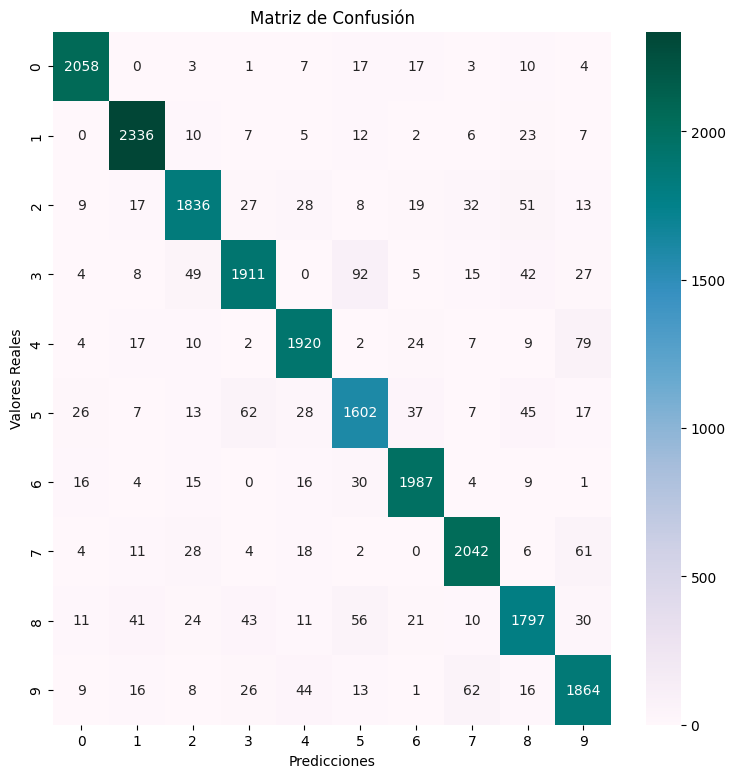

In [12]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_LR, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Por último, se selecciona una muestra aleatoria de 8 dígitos entre el conjunto de imágenes de prueba y se muestran los valores de predicción del modelo y el valor real correspondiente a la imagen.

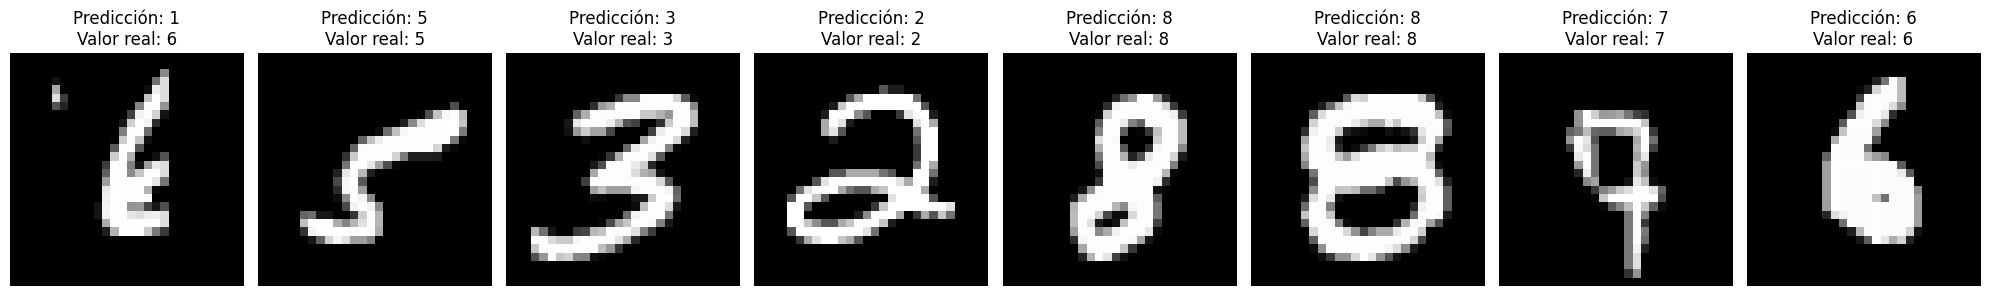

In [13]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_LR[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. K-Vecinos

El segundo modelo que vamos a utilizar corresponda a [K-Nearest Neighbors (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) también conocido como K-Vecinos o K-Vecinos más cercanos. Se trata de un modelo que almacena los datos y establece distancias entre ellos, al presentarse un dato desconocido este lo asigna a la clase con la que su distancia sea menor, es útil para tareas de clasificación como la nuestra.

---

### 2.1. Import

Se importa el modelo de SciKitLearn.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

### 2.2. Métricas

De manera similar al modelo anterior, KNN también posee hiperparámetros que debemos ajustar para tener el mejor rendimiento posible, estos son los siguientes:

* n_neighbors: Define el valor de K, es decir, el número de vecinos cercanos que se tendrán en cuenta al clasificar un dato nuevo, es el hiperparámetro más importante de este modelo.
* metric: Este define la forma en la que se entiende que tan cerca se encuentran dos puntos, es decir, como se va a medir la distancia entre puntos.
* weights: Controla el peso o influencia que tienen los vecinos al momento de clasificar un punto nuevo, todos los vecinos pueden tener la misma influencia o darle mayor importancia a los más cercanos


In [15]:
#Se definen los rangos de valores a estimar
param_grid_KNN = {
    'n_neighbors': range(2, 5),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
    }

Nota: Dado que la estimación de hiperparámetros es costosa a nivel computacional, se dejan los valores óptimos para los hiperparámetros de KNN obtenidos en una iteración anterior del notebook, esto con la finalidad de agilizar el proceso de entrenamiento.

In [16]:
#Mejores valores para los hiperparámetros
param_grid_KNN = {
    'n_neighbors': [3],
    'weights': ['distance'],
    'metric': ['euclidean']
    }

Las métricas mencionadas en Regresión Logística también aplican en este modelo, por lo que no se volverán a definir de forma explícita, sin embargo cabe mencionar que la métrica en la que nos enfocaremos será la precisión o accuracy. De igual manera se repetirá el uso de la validación cruzada para mejorar la generalización del modelo

In [17]:
#Se usa GridSearchCV para los calculos de los hiperparámetros y de los scores
grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid_KNN, cv = 5, scoring = 'accuracy')

#Shhhh... Machine is Learning (again)
grid_search_KNN.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_KNN.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_KNN.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Métricas del modelo:
Accuracy: 96.99%


### 2.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [18]:
#Se guarda el mejor modelo obtenido de GridSearchCV()
modelKNN = grid_search_KNN.best_estimator_

#Primeras predicciones del modelo:
y_pred_KNN = modelKNN.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_KNN = modelKNN.score(X_test, y_test)

#Se calcula la matriz de confusión asociada
conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)

Resultados obtenidos de la predicción y la precisión de la misma:

In [19]:
print(f"Predicciones: {y_pred_KNN}\nValores Reales: {y_test}\n")
print(f"Precisión de la predicción: {acc_pred_KNN * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Precisión de la predicción: 97.27%


### 2.4. Resultados generales

A continuación se muestra la matriz de confusión obtenida para este modelo, la interpretación de la misma es igual a la del modelo anterior. Con esta herramiento podremos observar a detalle el rendimiento del modelo en el conjunto de prueba.

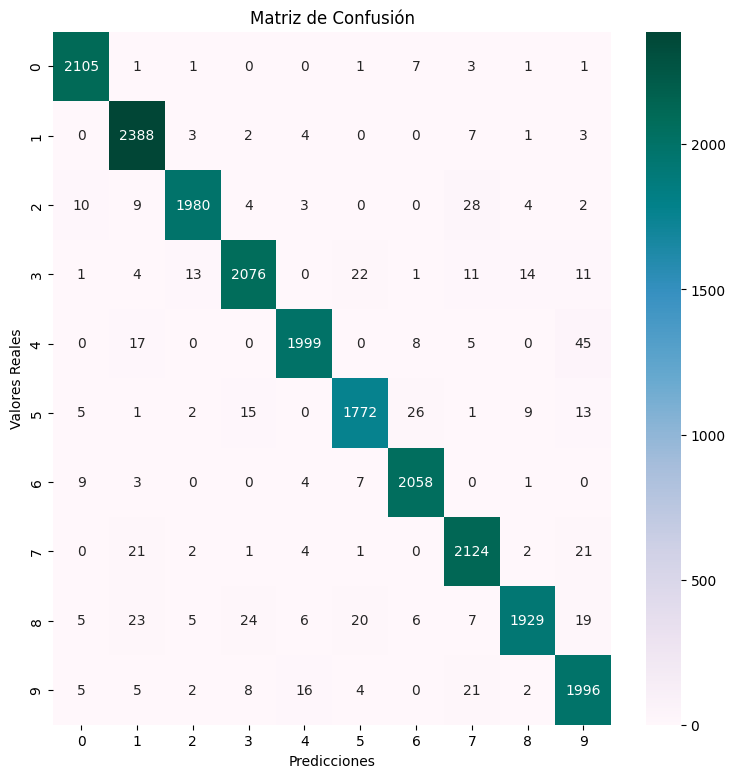

In [20]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_KNN, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

De igual forma, se toma una muestra aleatoria de 8 imágenes del conjunto de prueba y se muestran los valores de la predicción realizada por el modelo junto al valor real correspondiente a la imagen.

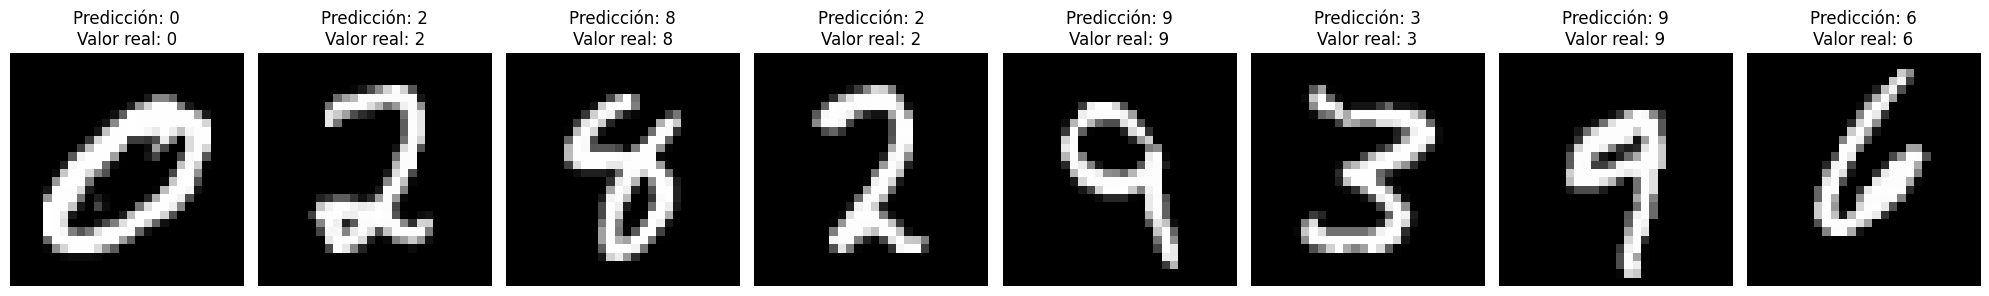

In [21]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_KNN[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. SVM

El último modelo que usaremos en este notebook será [SVM](https://scikit-learn.org/stable/modules/svm.html) conocido como Máquinas de Vectores de Soporte. Este algoritmo se encarga de calcular el hiperplano que mejor separe a los datos en las diferentes clases.

---

### 3.1. Import

Dad que estamos en un problema de clasificación, debemos hacer uso de la clase [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) de SVM en SciKitLearn.

In [22]:
from sklearn.svm import SVC

### 3.2. Métricas

De forma similar a los 2 modelos anteriores, se tienen un conjunto de hiperparámetros que debemos ajustar para obtener el mejor rendimiento posible del modelo. En el caso de SVM, son los siguientes:

* Kernel: Este define cómo se mapean los datos a un espacio de mayor dimensión donde sea posible encontrar un hiperplano lineal que separe las clases.
* C: Este parámetro se encarga de la regularización, su valor determina si se le da prioridad a maximizar el margen o a la clasificación correcta de los puntos de entrenamiento.
* gamma: Este parámetro solo aplica con kernels no lineales, controla el radio de influencia de cada punto.

In [23]:
#Se definen los rangos de valores a estimar
param_grid_SVM = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

Nota: Dado que la estimación de hiperparámetros es costosa a nivel computacional, se dejan los valores óptimos para los hiperparámetros para SVM obtenidos en una iteración anterior del notebook, esto con la finalidad de agilizar el proceso de entrenamiento.

In [24]:
#Mejores valores para los hiperparámetros
param_grid_SVM = {
    'C': [10],
    'kernel': ['rbf']
}

Las métricas mencionadas en Regresión Logística y en KNN también aplican en este modelo, por lo que no se volverán a definir de forma explícita. En este caso se también vamos a enfocarnos en la precisión o accuracy.

Al mismo tiempo, se usará validación cruzada para obtener que el modelo generalice de forma correcta.

In [25]:
grid_search_SVM = GridSearchCV(SVC(), param_grid_SVM, cv = 5, scoring = 'accuracy')

#Be quiet... Machine's Learnig over here
grid_search_SVM.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_SVM.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_SVM.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'C': 10, 'kernel': 'rbf'}

Métricas del modelo:
Accuracy: 98.16%


### 3.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [26]:
#Se hace uso del mejor modelo obtenido de GridSearchCV()
modelSVM = grid_search_SVM.best_estimator_

#Primeras predicciones del modelo:
y_pred_SVM = modelSVM.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_SVM = accuracy_score(y_test, y_pred_SVM)

#Se calcula la matriz de confusión asociada
conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)

Resultados obtenidos de la predicción junto a la precisión de la misma:

In [27]:
print(f"Predicciones: {y_pred_SVM}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_SVM * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 98.24%


### 3.4. Resultados generales

Para SVM también nos resulta útil hacer uso de la matriz de confusión, ya que nos permite observar detalladamente el resultado de la predicción realizada y así comprender el comportamiento del modelo.

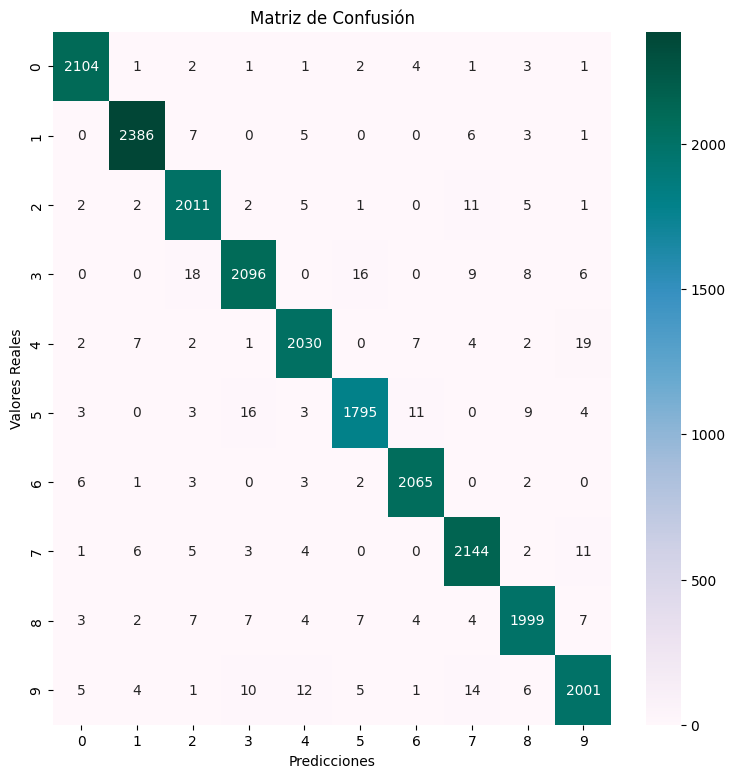

In [28]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_SVM, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Por último, se toma una muesra aleatoria de 8 imágenes extraídas del conjunto de prueba, se muestran sus valores reales y la predicción realizada por el modelo.

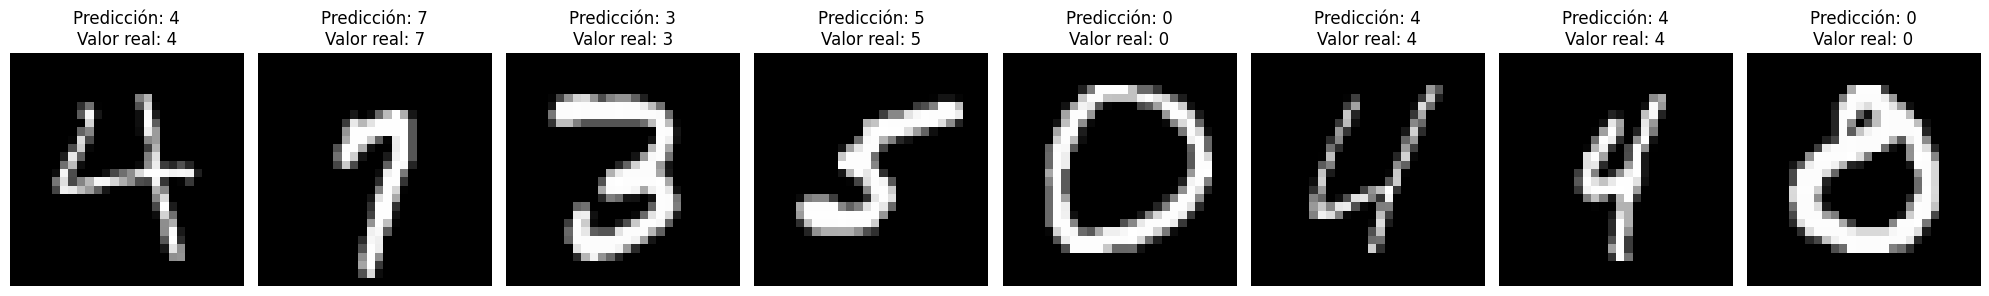

In [29]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_SVM[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusiones


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
